 # (Continue) Pretraining a GET Model on PBMC 10k ATAC


 This tutorial demonstrates how to train a GET model to predict ATAC-seq peaks using motif information. We'll cover:

 1. Loading and configuring the model

 2. Training without a pretrained checkpoint

 3. Training with a pretrained checkpoint

 4. Comparing the results



 ## Setup

 First, let's import the necessary modules and set up our configuration.
 
 Note:
 If you run from a Mac, make sure you use the jupyter notebook rather than the VSCode interactive python editor as the later seems to have issue with multiple workers.
 If you run from Linux, both should work fine.

In [1]:
#%%
from get_model.config.config import export_config, load_config, load_config_from_yaml, pretty_print_config
from get_model.run_region import run_zarr as run

/home/yoyomanzoor/Crucial/get/lib/python3.12/site-packages/seqlogo/seqlogo.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/yoyomanzoor/Crucial/get/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [47]:
import os
os.chdir('/home/yoyomanzoor/Documents/get_multimodel')

 ## Configuration



 We'll start by loading a predefined configuration and customizing it for our needs.

 The base configuration is in `get_model/config/finetune_tutorial.yaml`

In [2]:
celltype_for_modeling = [
    'memory_b',
    'cd14_mono',
    'gdt',
    'cd8_tem_1',
    'naive_b',
    'mait',
    'intermediate_b',
    'cd4_naive',
    'cd8_tem_2',
    'cd8_naive',
    'cd4_tem',
    'cd4_tcm',
    'cd16_mono',
    'nk',
    'cdc',
    'treg']
# cfg = load_config('finetune_tutorial') # load the predefined finetune tutorial config
cfg = load_config('finetune_tutorial') # load the predefined finetune tutorial config
cfg.run.project_name = 'pretrain_pbmc' # this is a unique name for this project
cfg.training.warmup_epochs = 10
cfg.dataset.leave_out_celltypes = 'cd8_tem_1'
cfg.dataset.zarr_path = "./pbmc10k_multiome.zarr" # the tutorial data which contains astrocyte atac & rna
cfg.dataset.celltypes = ','.join(celltype_for_modeling) # the celltypes you want to pretrain
cfg.dataset.leave_out_chromosomes = None # pretrain on all chromosomes
cfg.run.use_wandb=True # this is a logging system, you can turn it off by setting it to False
cfg.training.epochs = 20 # this is the number of epochs you want to train for
cfg.training.val_check_interval = 1.0 # validation check every epochs; this is for mac because the evaluation step is slow on it somehow...

 ### Model Selection


 We'll use the GETRegionPretrain model, which is designed to use contextual motif(+atac) information to target motif(+atac) information

 This model is particularly useful for understanding the relationship between motifs and chromatin accessibility.

In [3]:
#%%
# Switch model to finetune ATAC model
cfg.model = load_config_from_yaml('get_model/config/model/GetRegionDiffusion.yaml').model
# cfg.model = load_config('model/GETRegionPretrain').model.model
cfg.dataset.mask_ratio = 0.5 # mask 50% of the motifs. This has to be set for pretrain dataloader to generate proper mask

 ## Continue Training With Pretrained Checkpoint Using LoRA



 Now, let's train the model using a pretrained checkpoint. This checkpoint was trained on a large dataset

 and should help the model learn faster and potentially achieve better performance.



 Note: You'll need to download the checkpoint first:

 ```bash

 aws s3 cp s3://2023-get-xf2217/get_demo/checkpoints/regulatory_inference_checkpoint_fetal_adult/pretrain_fetal_adult/checkpoint-799.pth ./checkpoint-799.pth

 ```

In [8]:
#%%
# now train the model with a pretrain checkpoint
cfg.run.run_name = 'diffusion_pbmc_from_pretrain_lora'
cfg.machine.codebase = "/home/yoyomanzoor/Documents/get_multimodel/"
cfg.machine.output_dir = "/home/yoyomanzoor/Crucial/get_data/output"
cfg.dataset.zarr_path = "/home/yoyomanzoor/Crucial/get_data/annotation_dir/pbmc10k_multiome.zarr"
cfg.finetune.checkpoint = '/home/yoyomanzoor/Documents/get_multimodel/tutorials/checkpoint-799.pth'
cfg.finetune.model_key = "model"
cfg.finetune.rename_config = {
  "encoder.head.": "head_mask.",
  "encoder.region_embed": "region_embed",
  "region_embed.proj.": "region_embed.embed.",
  "encoder.cls_token": "cls_token",
}
# strict=False allows loading base model weights while leaving diffusion components randomly initialized
cfg.finetune.strict = False
cfg.finetune.use_lora = True
cfg.finetune.layers_with_lora = ['region_embed', 'encoder']

In [ ]:
export_config(cfg, "tutorials/yamls/exported_diffusion_pbmc_lora.yaml")

In [ ]:
cfg = load_config_from_yaml("tutorials/yamls/exported_diffusion_pbmc_lora.yaml")

Load ckpt from /home/yoyomanzoor/Documents/get_multimodel/tutorials/checkpoint-799.pth
Load state_dict by model_key = model


wandb: Currently logged in as: smanzoor (smanzoor-university-of-michigan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


 13%|████████████████████████████████████████▏                                                                                                                                                                                                                                                                    | 2/15 [00:00<00:01, 10.75it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 27%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                            | 4/15 [00:00<00:00, 12.95it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 8/15 [00:00<00:00, 12.40it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 10/15 [00:00<00:00, 11.96it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 14/15 [00:01<00:00, 11.19it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.85it/s]


Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
masked_mse,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
masked_pearson,▁▄▅▆▆▇▇▇▇▇▇█████████
masked_r2,▁▄▅▆▆▇▇▇▇▇▇▇████████
train_loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_masked_loss,█▅▅▅▄▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_masked_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,19
masked_mse,0.16652


{'train_masked_loss': tensor(0.1642),
 'train_loss': tensor(0.1642),
 'val_masked_loss': tensor(0.1665),
 'masked_pearson': tensor(0.9132),
 'masked_mse': tensor(0.1665),
 'masked_r2': tensor(0.8335),
 'val_loss': tensor(0.1665)}

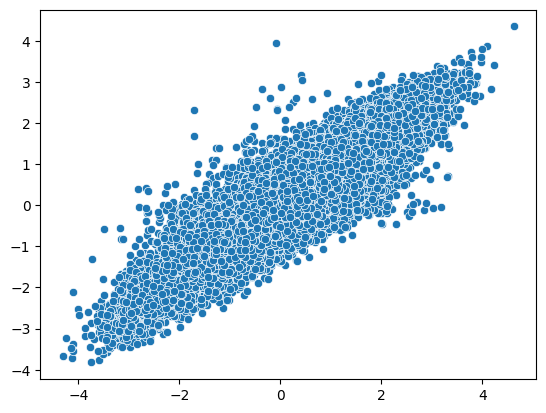

In [11]:
trainer = run(cfg)
trainer.callback_metrics